# 4.3 Refit best and transfer test on PTB dataset




## 1. Imports

In [1]:
import os
import sys
from pathlib import Path
import warnings
from typing import Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import xgboost as xgb

# Show working directory
print(os.getcwd())

# Ensure `src` is importable when running from the notebook
sys.path.append(str((Path.cwd() / "src").resolve()))

# Custom utilities
from src.utils.preprocessing import (
    load_processed_dataset,
    build_full_suffix as pp_build_full_suffix,
    generate_all_processed_datasets,
)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

/home/christianm/Projects/Repos/heartbeat_classification


## 2. Refit best Model from part 4

In [24]:
params = {"classifier__colsample_bytree": 0.9, "classifier__gamma": 0.0,
               "classifier__learning_rate": 0.2, "classifier__max_depth": 9,
               "classifier__min_child_weight": 5, "classifier__n_estimators": 500,
               "classifier__reg_alpha": 0.2, "classifier__reg_lambda": 0.05,
               "classifier__subsample": 0.7}

# Preprocessed data sampling (loader) vs. model-time sampler
DATA_DIR = "data/processed/mitbih"
sampling_method = "No_Sampling"   # dataset loader suffix
model_sampler = "SMOTE"           # sampler applied inside the pipeline

model_name = "XGBoost"
remove_outliers = False

### XGBoost, SMOTE, no outlier removal,	no feature engineering

In [25]:
def prepare_dataset_with_sampling(
    data_dir: str = DATA_DIR,
    sampling_method: str = "No_Sampling",
    remove_outliers: bool = False
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    """Load an existing processed dataset for the given configuration.

    Datasets are assumed to be pre-generated by preprocessing utilities. This
    function never overwrites or generates new data; it only loads.
    """
    # Ensure all datasets are generated once (no-op if already done)
    generate_all_processed_datasets(data_dir=data_dir, only_once=True)

    full_suffix = pp_build_full_suffix(sampling_method, remove_outliers)
    split = load_processed_dataset(data_dir=data_dir, sampling_suffix=full_suffix)

    X_train_res = split.X_train.values
    y_train_res = split.y_train.values
    X_val = split.X_val.values if split.X_val is not None else None
    y_val = split.y_val.values if split.y_val is not None else None

    return X_train_res, X_val, y_train_res, y_val



print(f"\n{'='*80}")
print(f"Refitting {model_name} with best parameters and transferring to PTB (5-class as-is)")
print(f"Data sampling (loader): {sampling_method} | Model sampler: {model_sampler} | Outlier removal: {remove_outliers}")
print(f"{'='*80}")

# 1) Train multi-class on MIT-BIH (as-is, 5 classes)
X_train, X_val, y_train, y_val = prepare_dataset_with_sampling(
    sampling_method=sampling_method,
    remove_outliers=remove_outliers
)

best_params_clean = {k.replace("classifier__", ""): v for k, v in params.items()}
estimator = Pipeline([
    ("sampler", SMOTE(random_state=42)),
    ("classifier", xgb.XGBClassifier(
        **best_params_clean,
        objective="multi:softprob",
        num_class=5,
        n_jobs=-1,
        random_state=42,
        eval_metric="mlogloss",
    )),
])

# Fit once
estimator.fit(X_train, y_train)

# Evaluate on MIT validation set first
y_pred_mit = estimator.predict(X_val)
mit_accuracy = accuracy_score(y_val, y_pred_mit)
mit_precision_macro, mit_recall_macro, mit_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_pred_mit, average='macro', zero_division=0
)
mit_labels = np.unique(np.concatenate([y_train, y_val]))
mit_precision_per_class, mit_recall_per_class, mit_f1_per_class, _ = precision_recall_fscore_support(
    y_val, y_pred_mit, average=None, labels=mit_labels, zero_division=0
)
mit_confusion = confusion_matrix(y_val, y_pred_mit, labels=mit_labels)

print(f"\nMIT-BIH Validation Metrics:")
print(f"Accuracy: {mit_accuracy:.4f}")
print(f"F1-Macro: {mit_f1_macro:.4f}")
print(f"Precision-Macro: {mit_precision_macro:.4f}")
print(f"Recall-Macro: {mit_recall_macro:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip(mit_labels, mit_f1_per_class):
    print(f"  Class {int(lbl)}: {f1:.4f}")
print(f"\nMIT-BIH Confusion Matrix (rows=true, cols=pred):\n{mit_confusion}")



Refitting XGBoost with best parameters and transferring to PTB (5-class as-is)
Data sampling (loader): No_Sampling | Model sampler: SMOTE | Outlier removal: False
Loading processed X_train dataset from: data/processed/mitbih/X_train.csv
Loading processed y_train dataset from: data/processed/mitbih/y_train.csv

MIT-BIH Validation Metrics:
Accuracy: 0.9849
F1-Macro: 0.9217
Precision-Macro: 0.9293
Recall-Macro: 0.9148

Per-class F1 scores:
  Class 0: 0.9922
  Class 1: 0.8538
  Class 2: 0.9592
  Class 3: 0.8171
  Class 4: 0.9864

MIT-BIH Confusion Matrix (rows=true, cols=pred):
[[14405    43    23    14     9]
 [   74   365     5     0     1]
 [   37     1  1106     9     5]
 [   12     0    11   105     0]
 [   15     1     3     1  1266]]


In [26]:
"""
Confusion matrix visualization utilities.

Provides a clean, simple function to pretty print a confusion matrix
using seaborn/matplotlib.
"""
from typing import List, Optional, Sequence, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def plot_confusion_matrix(
    matrix: Union[np.ndarray, Sequence[Sequence[int]]],
    class_names: Optional[List[str]] = None,
    normalize: Optional[str] = None,
    figsize: Tuple[int, int] = (8, 6),
    cmap: str = "Blues",
    fmt: Optional[str] = None,
    colorbar: bool = True,
    title: Optional[str] = None,
    annot: bool = True,
    annot_fontsize: int = 10,
    xtick_rotation: int = 0,
    ytick_rotation: int = 0,
) -> plt.Figure:
    """
    Pretty-print a confusion matrix with seaborn/matplotlib.
    Displays both normalized values and absolute counts if normalization is used.
    """
    # Convert to float
    cm = np.asarray(matrix, dtype=float)

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError("matrix must be a square 2D array")

    n_classes = cm.shape[0]
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    elif len(class_names) != n_classes:
        raise ValueError("class_names length must match matrix size")

    # Store absolute counts before normalization
    abs_cm = matrix.astype(int)

    # Normalization
    if normalize is not None:
        if normalize == "true":
            row_sums = cm.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            cm = cm / row_sums
        elif normalize == "pred":
            col_sums = cm.sum(axis=0, keepdims=True)
            col_sums[col_sums == 0] = 1.0
            cm = cm / col_sums
        elif normalize == "all":
            total = cm.sum()
            total = 1.0 if total == 0 else total
            cm = cm / total
        else:
            raise ValueError("normalize must be one of {'true','pred','all',None}")

    # Determine format
    if fmt is None:
        fmt = ".2f" if normalize else "d"

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Generate annotation labels (normalized + raw counts)
    if normalize is not None:
        annot_labels = np.empty_like(cm).astype(str)
        for i in range(n_classes):
            for j in range(n_classes):
                annot_labels[i, j] = f"{cm[i, j]:.2f}\n({abs_cm[i, j]})"
        fmt = ""  # we already control string formatting manually
    else:
        annot_labels = abs_cm

    # Draw heatmap
    sns.heatmap(
        cm,
        annot=annot_labels if annot else False,
        fmt=fmt,
        cmap=cmap,
        cbar=colorbar,
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5,
        linecolor="white",
        square=True,
        annot_kws={"fontsize": annot_fontsize},
        ax=ax,
    )

    # Axis labels and title
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    if title is None:
        title = "Confusion Matrix" + (" (normalized)" if normalize else "")
    ax.set_title(title, fontsize=12, fontweight="bold")

    # Ticks styling
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rotation, ha="center")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_rotation, va="center")

    fig.tight_layout()
    return fig


__all__ = ["plot_confusion_matrix"]


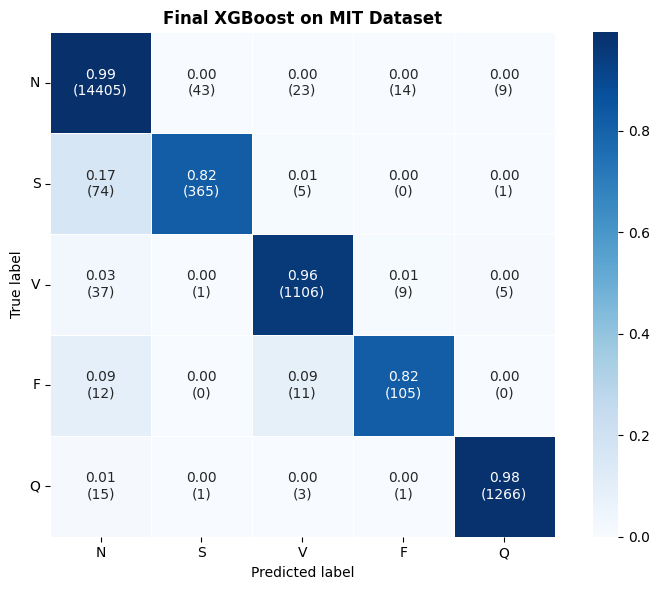

In [27]:
#from src.visualization.confusion_matrix import plot_confusion_matrix
class_names=["N", "S", "V", "F", "Q"]
fig = plot_confusion_matrix(
    mit_confusion,
    class_names=class_names,
    fmt=".2f",  # <-- float format,
    normalize="true",
    annot=True,
    title="Final XGBoost on MIT Dataset"
)
fig.show()


In [34]:
# Evaluate the fitted MIT-trained XGBoost on the entire PTB dataset (train + val)
from src.utils.preprocessing import prepare_ptbdb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


print("\n" + "="*80)
print("Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)")
print("="*80)

# Load PTB split (both train and test)
# validation is left out to compare 
ptb_dir = "/home/christianm/Projects/Repos/heartbeat_classification/data/processed/ptb"
X_ptb_train = pd.read_csv(f"{ptb_dir}/X_ptb_train.csv").values
y_ptb_train = pd.read_csv(f"{ptb_dir}/y_ptb_train.csv").iloc[:, 0].values.astype(int)
X_ptb_train_sm = pd.read_csv(f"{ptb_dir}/X_ptb_train_sm.csv").values
y_ptb_train_sm = pd.read_csv(f"{ptb_dir}/y_ptb_train_sm.csv").iloc[:, 0].values.astype(int)
X_ptb_test = pd.read_csv(f"{ptb_dir}/X_ptb_test.csv").values
y_ptb_test = pd.read_csv(f"{ptb_dir}/y_ptb_test.csv").iloc[:, 0].values.astype(int)
X_ptb_val = pd.read_csv(f"{ptb_dir}/X_ptb_val.csv").values
y_ptb_val = pd.read_csv(f"{ptb_dir}/y_ptb_val.csv").iloc[:, 0].values.astype(int)
X_ptb_full = np.vstack([X_ptb_train, X_ptb_test, X_ptb_val])
y_ptb_full = np.concatenate([y_ptb_train, y_ptb_test, y_ptb_val])

# Predict probabilities for 5 classes and map to binary (0 -> 0, 1/2/3/4 -> 1)
ptb_proba_5_full = estimator.predict_proba(X_ptb_full)
y_pred_ptb_5_full = np.argmax(ptb_proba_5_full, axis=1)

y_pred_ptb_bin_full = (y_pred_ptb_5_full != 0).astype(int)

# Metrics
acc_full = accuracy_score(y_ptb_full, y_pred_ptb_bin_full)
prec_macro_full, rec_macro_full, f1_macro_full, ptb_f1_per_class = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average="macro", zero_division=0
)

# Per-class metrics
ptb_prec_per_class, ptb_rec_per_class, ptb_f1_per_class, _ = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average=None, zero_division=0
)

ptb_confusion = confusion_matrix(y_ptb_full, y_pred_ptb_bin_full, labels=[0, 1])

# Distributions
unique_full, counts_full = np.unique(y_pred_ptb_5_full, return_counts=True)
pred_dist = {int(k): int(v) for k, v in zip(unique_full.tolist(), counts_full.tolist())}
true_dist = {int(k): int(v) for k, v in zip(*np.unique(y_ptb_full, return_counts=True))}

ptb_labels = [0, 1]

print(f"\nPTB-DB Test Metrics:")
print(f"Accuracy: {acc_full:.4f}")
print(f"F1-Macro: {f1_macro_full:.4f}")
print(f"Precision-Macro: {prec_macro_full:.4f}")
print(f"Recall-Macro: {rec_macro_full:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip(ptb_labels, ptb_f1_per_class):
    print(f"  Class {int(lbl)}: {f1:.4f}")

print(f"\PTB Confusion Matrix (rows=true, cols=pred):\n{cm_full}")




Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)

PTB-DB Test Metrics:
Accuracy: 0.3483
F1-Macro: 0.3251
Precision-Macro: 0.5866
Recall-Macro: 0.5362

Per-class F1 scores:
  Class 0: 0.4503
  Class 1: 0.1999
\PTB Confusion Matrix (rows=true, cols=pred):
[[3882  163]
 [9316 1184]]


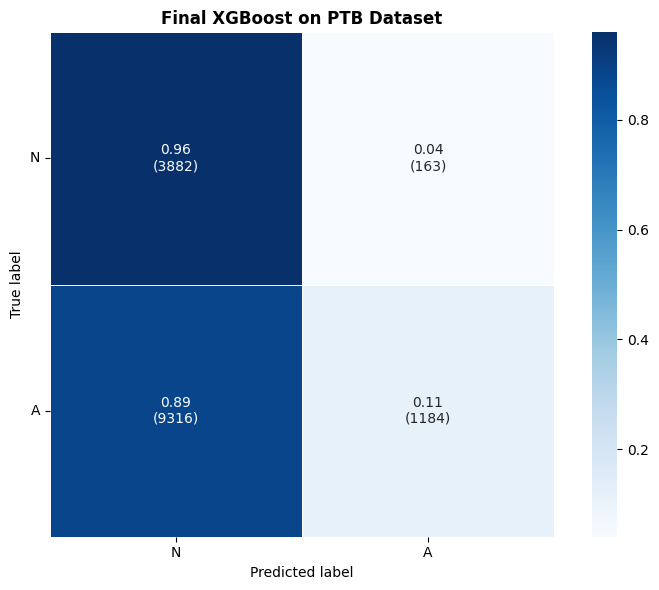

In [37]:
#from src.visualization.confusion_matrix import plot_confusion_matrix
class_names=["N", "A"]
fig = plot_confusion_matrix(
    ptb_confusion,
    class_names=class_names,
    fmt=".2f",  # <-- float format,
    normalize="true",
    annot=True,
    title="Final XGBoost on PTB Dataset"
)
fig.show()

In [ ]:
# Refit XGBoost on PTB (binary) with SMOTE using the same params, then evaluate on PTB full
print("\n" + "="*80)
print("Refitting XGBoost with best parameters and evaluating on PTB (binary) TEST using pre-processed dataset - leaving out validation dataset.")
print(f"Sampling: SMOTE | Outlier removal: {False}")
print("="*80)

# 2) Clean params from GridSearchCV (strip 'classifier__' prefix)
best_params_clean_ptb = {k.replace("classifier__", ""): v for k, v in params.items()}

print(f"Best Params: {best_params_clean_ptb}")

# 3) Build pipeline: SMOTE (train only) + XGBClassifier (binary)
pipe_ptb = Pipeline([
    ("sampler", SMOTE(random_state=42)),
    ("classifier", xgb.XGBClassifier(
        **best_params_clean_ptb,
        objective="binary:logistic",
        n_jobs=-1,
        random_state=42,
        eval_metric="logloss",
    )),
])

# 4) Fit on PTB train
pipe_ptb.fit(X_ptb_train, y_ptb_train)

# 5) Evaluate on PTB full (binary)
# Option A: use direct class predictions
y_pred_val = pipe_ptb.predict(X_ptb_test).astype(int)

# Option B (equivalent): threshold positive-class probability at 0.5
# proba_full = pipe_ptb.predict_proba(X_ptb_full)[:, 1]
# y_pred_ptb_full = (proba_full >= 0.5).astype(int)

# Metrics
acc_full = accuracy_score(y_ptb_full, y_pred_ptb_bin_full)
prec_macro_full, rec_macro_full, f1_macro_full, ptb_f1_per_class = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average="macro", zero_division=0
)
ptb_cm_full = confusion_matrix(y_ptb_test, y_pred_val, labels=[0, 1])

# Distributions
pred_labels, pred_counts = np.unique(y_pred_val, return_counts=True)
true_labels, true_counts = np.unique(y_ptb_full, return_counts=True)
pred_dist = dict(zip(pred_labels.tolist(), pred_counts.tolist()))
true_dist = dict(zip(true_labels.tolist(), true_counts.tolist()))

print("PTB (full) predicted binary distribution:", pred_dist)
print("PTB (full) true binary distribution:", true_dist)
print(f"PTB (full) Accuracy: {acc_full:.4f}")
print(f"PTB (full) F1-Macro: {f1_macro_full:.4f}")
print("PTB (full) Confusion Matrix (rows=true, cols=pred):\n", cm_full)


# Metrics
acc_full = accuracy_score(y_ptb_full, y_pred_ptb_bin_full)
prec_macro_full, rec_macro_full, f1_macro_full, ptb_f1_per_class = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average="macro", zero_division=0
)

# Per-class metrics
ptb_prec_per_class, ptb_rec_per_class, ptb_f1_per_class, _ = precision_recall_fscore_support(
    y_ptb_full, y_pred_ptb_bin_full, average=None, zero_division=0
)

ptb_confusion = confusion_matrix(y_ptb_full, y_pred_ptb_bin_full, labels=[0, 1])

# Distributions
unique_full, counts_full = np.unique(y_pred_ptb_5_full, return_counts=True)
pred_dist = {int(k): int(v) for k, v in zip(unique_full.tolist(), counts_full.tolist())}
true_dist = {int(k): int(v) for k, v in zip(*np.unique(y_ptb_full, return_counts=True))}

ptb_labels = [0, 1]

print(f"\nPTB-DB Test Metrics:")
print(f"Accuracy: {acc_full:.4f}")
print(f"F1-Macro: {f1_macro_full:.4f}")
print(f"Precision-Macro: {prec_macro_full:.4f}")
print(f"Recall-Macro: {rec_macro_full:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip(ptb_labels, ptb_f1_per_class):
    print(f"  Class {int(lbl)}: {f1:.4f}")

print(f"\PTB Confusion Matrix (rows=true, cols=pred):\n{ptb_confusion}")

In [ ]:
#from src.visualization.confusion_matrix import plot_confusion_matrix
class_names=["N", "A"]
fig = plot_confusion_matrix(
    ptb_confusion,
    class_names=class_names,
    fmt=".2f",  # <-- float format,
    normalize="true",
    annot=True,
    title="Final XGBoost on PTB Dataset"
)
fig.show()

In [ ]:
# Evaluate PTB-trained binary model on MIT dataset
print("\n" + "="*80)
print("Transfer Learning: Evaluating PTB-trained binary XGBoost on MIT-BIH dataset")
print("="*80)

# Use MIT validation set (already loaded from previous cells)
# X_val and y_val are from MIT-BIH

# Get binary predictions from PTB model on MIT data
y_pred_mit_binary = pipe_ptb.predict(X_val)

# ============================================================================
# Evaluation 1: Multi-class abnormal mapping
# Map MIT classes: 0→0 (normal), {1,2,3,4}→1 (all abnormal)
# ============================================================================
print("\n" + "-"*80)
print("Evaluation 1: All abnormal classes (1-4) mapped to binary class 1")
print("-"*80)

y_true_mit_multi_binary = (y_val != 0).astype(int)  # 0 stays 0, all others become 1

acc_1 = accuracy_score(y_true_mit_multi_binary, y_pred_mit_binary)
prec_macro_1, rec_macro_1, f1_macro_1, _ = precision_recall_fscore_support(
    y_true_mit_multi_binary, y_pred_mit_binary, average="macro", zero_division=0
)
prec_per_class_1, rec_per_class_1, f1_per_class_1, _ = precision_recall_fscore_support(
    y_true_mit_multi_binary, y_pred_mit_binary, average=None, labels=[0, 1], zero_division=0
)
cm_1 = confusion_matrix(y_true_mit_multi_binary, y_pred_mit_binary, labels=[0, 1])

# Distribution info
true_dist_multi = {int(k): int(v) for k, v in zip(*np.unique(y_true_mit_multi_binary, return_counts=True))}
pred_dist_multi = {int(k): int(v) for k, v in zip(*np.unique(y_pred_mit_binary, return_counts=True))}

print(f"\nMIT true binary distribution (all abnormal): {true_dist_multi}")
print(f"PTB model predictions distribution: {pred_dist_multi}")
print(f"\nAccuracy: {acc_1:.4f}")
print(f"F1-Macro: {f1_macro_1:.4f}")
print(f"Precision-Macro: {prec_macro_1:.4f}")
print(f"Recall-Macro: {rec_macro_1:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip([0, 1], f1_per_class_1):
    class_name = "Normal" if lbl == 0 else "Abnormal (all 1-4)"
    print(f"  Class {lbl} ({class_name}): {f1:.4f}")
print(f"\nConfusion Matrix (rows=true, cols=pred):\n{cm_1}")

# ============================================================================
# Evaluation 2: Single-class abnormal mapping
# Map MIT classes: 0→0 (normal), 1→1 (abnormal), drop classes {2,3,4}
# ============================================================================
print("\n" + "-"*80)
print("Evaluation 2: Only class 1 mapped to binary class 1 (classes 2,3,4 dropped)")
print("-"*80)

# Create mask: keep only MIT classes 0 and 1
keep_mask = (y_val == 0) | (y_val == 1)
y_val_filtered = y_val[keep_mask]
X_val_filtered = X_val[keep_mask]
y_pred_mit_binary_filtered = pipe_ptb.predict(X_val_filtered)

# Map to binary: 0→0, 1→1 (already binary since we filtered)
y_true_mit_single_binary = y_val_filtered.astype(int)

acc_2 = accuracy_score(y_true_mit_single_binary, y_pred_mit_binary_filtered)
prec_macro_2, rec_macro_2, f1_macro_2, _ = precision_recall_fscore_support(
    y_true_mit_single_binary, y_pred_mit_binary_filtered, average="macro", zero_division=0
)
prec_per_class_2, rec_per_class_2, f1_per_class_2, _ = precision_recall_fscore_support(
    y_true_mit_single_binary, y_pred_mit_binary_filtered, average=None, labels=[0, 1], zero_division=0
)
cm_2 = confusion_matrix(y_true_mit_single_binary, y_pred_mit_binary_filtered, labels=[0, 1])

# Distribution info
true_dist_single = {int(k): int(v) for k, v in zip(*np.unique(y_true_mit_single_binary, return_counts=True))}
pred_dist_single = {int(k): int(v) for k, v in zip(*np.unique(y_pred_mit_binary_filtered, return_counts=True))}
dropped_count = len(y_val) - len(y_val_filtered)

print(f"\nMIT samples: {len(y_val)} total, {dropped_count} dropped (classes 2,3,4), {len(y_val_filtered)} kept")
print(f"MIT true binary distribution (class 1 only): {true_dist_single}")
print(f"PTB model predictions distribution: {pred_dist_single}")
print(f"\nAccuracy: {acc_2:.4f}")
print(f"F1-Macro: {f1_macro_2:.4f}")
print(f"Precision-Macro: {prec_macro_2:.4f}")
print(f"Recall-Macro: {rec_macro_2:.4f}")
print(f"\nPer-class F1 scores:")
for lbl, f1 in zip([0, 1], f1_per_class_2):
    class_name = "Normal" if lbl == 0 else "Abnormal (class 1 only)"
    print(f"  Class {lbl} ({class_name}): {f1:.4f}")
print(f"\nConfusion Matrix (rows=true, cols=pred):\n{cm_2}")